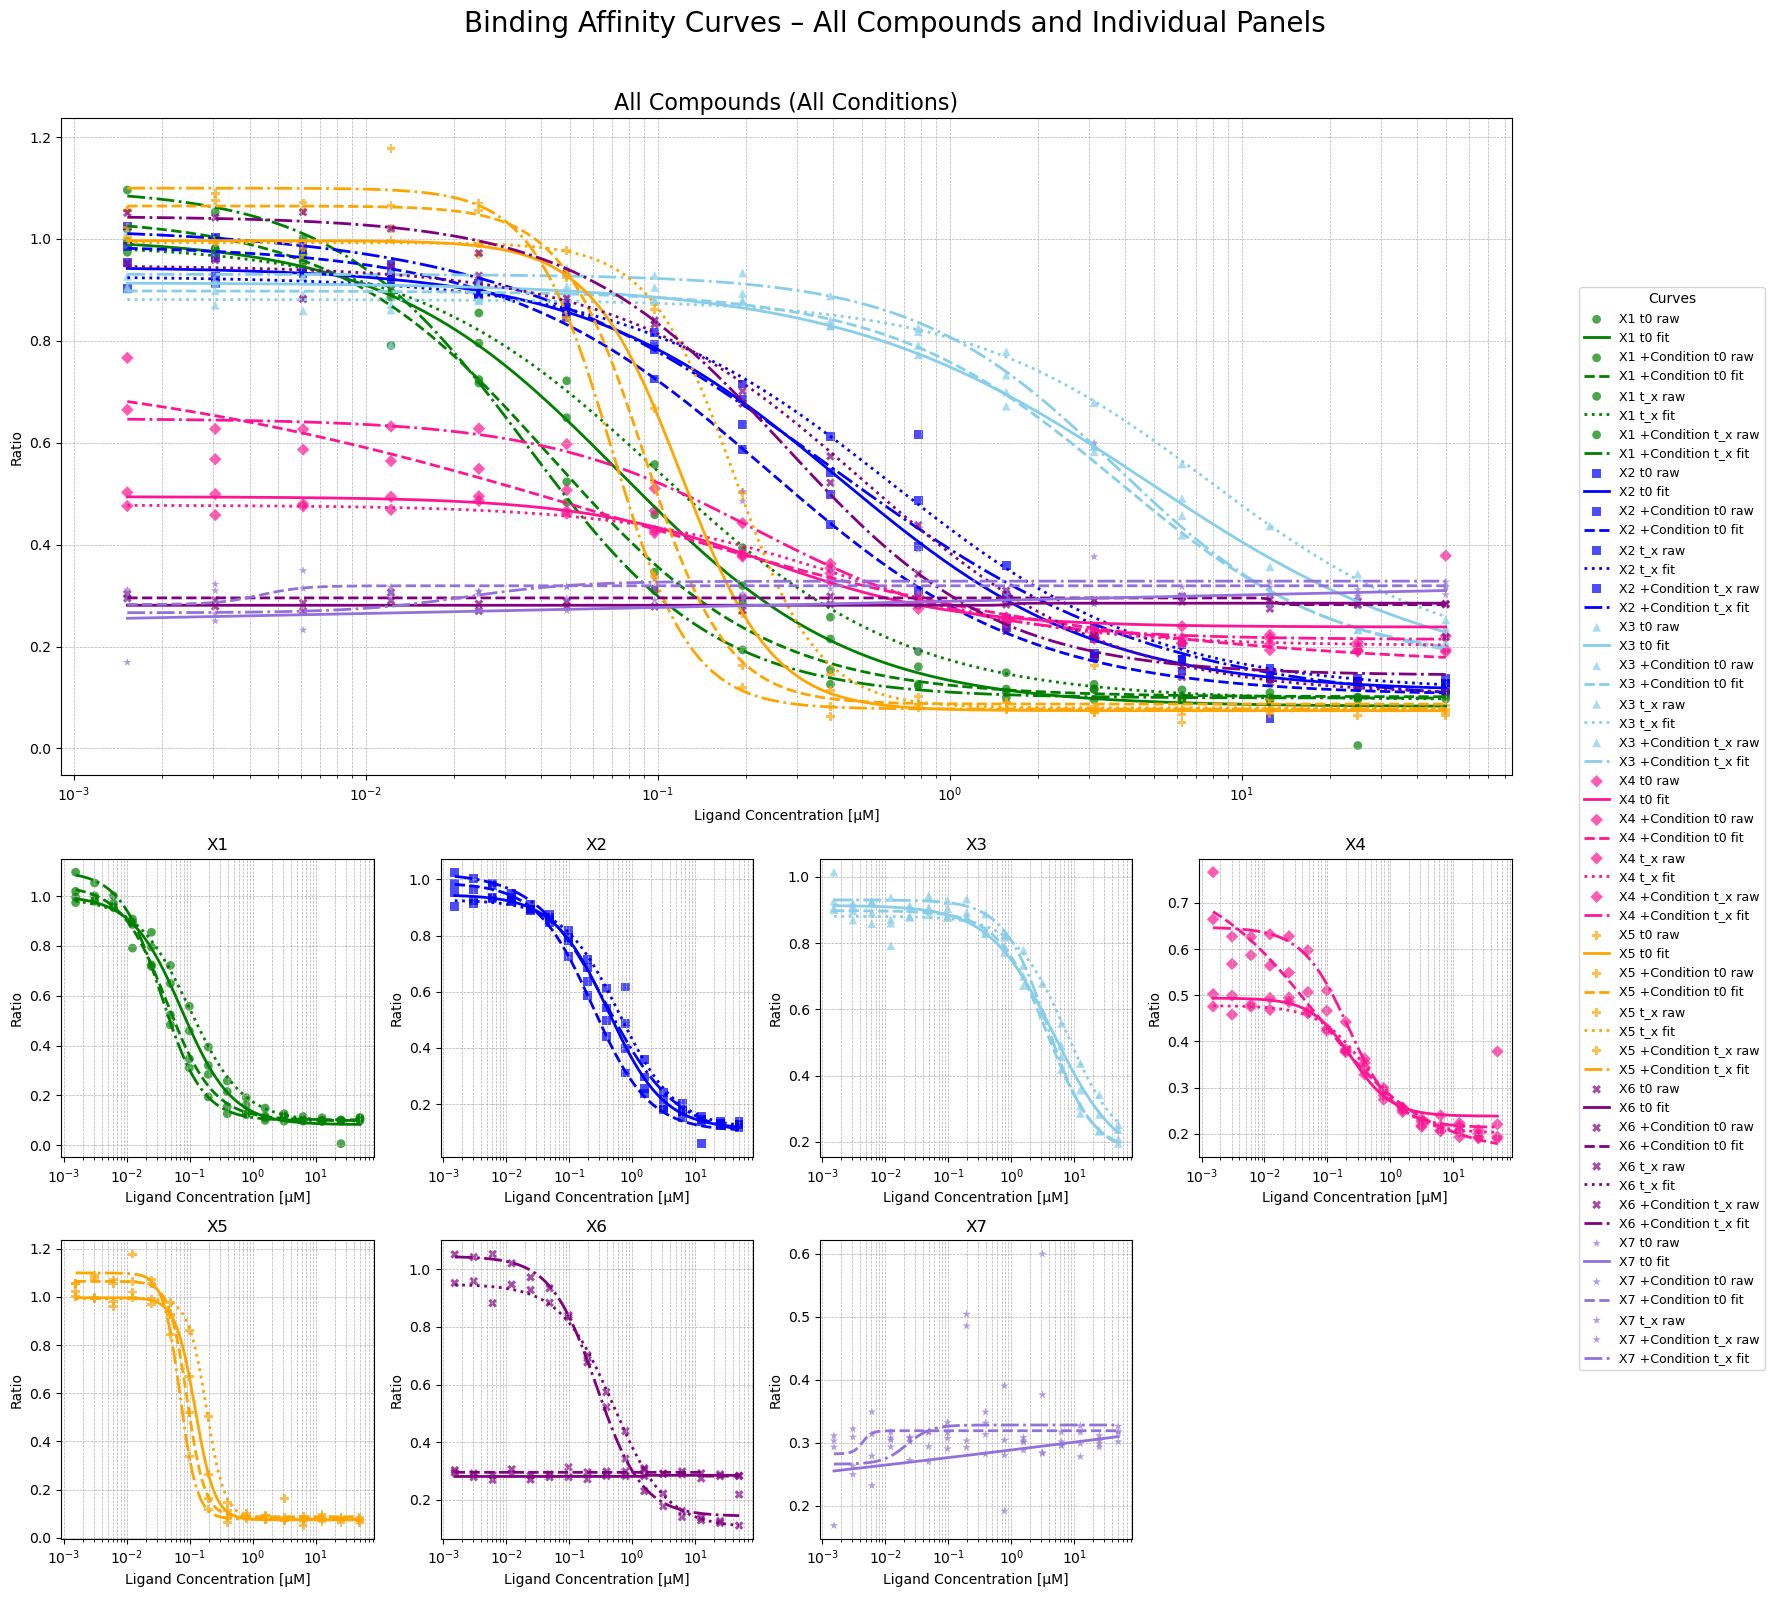

In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ROOT = Path.cwd().resolve()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent
os.chdir(ROOT)

DATA_DIR = Path("synthetic-data") / "affinity"
FIT_FILE = Path("outputs") / "affinity" / "logistic_fit_results.csv"
FIG_DIR = Path("outputs") / "affinity" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

UNIFY_Y_SMALL = False
SMALL_YLIM = (0.0, 1.2)
UNIFY_Y_BIG = False
BIG_YLIM = (0.0, 1.2)

compounds = [f"X{i}" for i in range(1, 8)]
fit_df = pd.read_csv(FIT_FILE)

def four_param_logistic(x, A, B, C, D):
    return D + (A - D) / (1 + (x / C) ** B)

colors = {
    "X1": "green",
    "X2": "blue",
    "X3": "skyblue",
    "X4": "deeppink",
    "X5": "orange",
    "X6": "purple",
    "X7": "mediumpurple",
}

markers = {
    "X1": "o",
    "X2": "s",
    "X3": "^",
    "X4": "D",
    "X5": "P",
    "X6": "X",
    "X7": "*",
}

linestyles = ["solid", "dashed", "dotted", "dashdot"]
conditions_order = ["t0", "+Condition t0", "t_x", "+Condition t_x"]

def plot_compound(ax, compound):
    raw = pd.read_csv(DATA_DIR / f"synth_{compound}.csv")
    fits = fit_df[(fit_df["compound"] == compound) & (fit_df["EC50 (C, µM)"].notna())]

    for idx, cond in enumerate(conditions_order):
        sub_raw = raw[raw["Condition"] == cond].copy()
        if not sub_raw.empty:
            ax.scatter(
                sub_raw["X"], sub_raw["Y"],
                marker=markers[compound], s=40, alpha=0.7,
                c=colors[compound], edgecolor="none",
                label=f"{compound} {cond} raw"
            )

        sub_fit = fits[fits["condition"] == cond]
        if sub_fit.empty or sub_raw.empty:
            continue

        A = float(sub_fit["Top (A)"].iloc[0])
        B = float(sub_fit["Slope (B)"].iloc[0])
        C = float(sub_fit["EC50 (C, µM)"].iloc[0])
        D = float(sub_fit["Bottom (D)"].iloc[0])

        x_min = max(float(sub_raw["X"].min()), 1e-9)
        x_max = float(sub_raw["X"].max())
        x = np.logspace(np.log10(x_min), np.log10(x_max), 300)
        y = four_param_logistic(x, A, B, C, D)

        ax.plot(
            x, y,
            linewidth=2,
            linestyle=linestyles[idx % len(linestyles)],
            c=colors[compound],
            label=f"{compound} {cond} fit"
        )

    ax.set_xscale("log")
    ax.set_xlabel("Ligand Concentration [µM]")
    ax.set_ylabel("Ratio")
    ax.set_title(compound)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

fig = plt.figure(figsize=(18, 16))
gs = gridspec.GridSpec(3, 5, figure=fig, height_ratios=[2.2, 1, 1], width_ratios=[1, 1, 1, 1, 0.6])

ax_big = fig.add_subplot(gs[0, :4])
for compound in compounds:
    plot_compound(ax_big, compound)

ax_big.set_title("All Compounds (All Conditions)", fontsize=16)
if UNIFY_Y_BIG:
    ax_big.set_ylim(*BIG_YLIM)

handles, labels = ax_big.get_legend_handles_labels()

for i, compound in enumerate(compounds):
    r = 1 + i // 4
    c = i % 4
    ax = fig.add_subplot(gs[r, c])
    plot_compound(ax, compound)
    if UNIFY_Y_SMALL:
        ax.set_ylim(*SMALL_YLIM)

ax_legend = fig.add_subplot(gs[:, 4])
ax_legend.axis("off")
ax_legend.legend(handles, labels, loc="center", fontsize=9, frameon=True, title="Curves", title_fontsize=10)

fig.suptitle("Binding Affinity Curves – All Compounds and Individual Panels", fontsize=20, y=0.995)
fig.tight_layout(rect=[0, 0, 1, 0.98])

plt.savefig(FIG_DIR / "binding_affinity_big_all_plus_panels.png", dpi=300, bbox_inches="tight")
plt.savefig(FIG_DIR / "binding_affinity_big_all_plus_panels.pdf", bbox_inches="tight")
plt.show()